In [161]:
import sys
import os

project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [162]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from data.data_loader import generateGauss
from utils.integral import grid
from Models.clustering import FCF
from utils.vis import plotHeatmap_U, plotPDF_Theta, plot_OF, temp, plot_silhouette_values, plot_CVI_with_k

In [163]:
import numpy as np

def generateUniform(lows, highs, grid_x):
    """
    lows, highs : mảng 1-D, cùng độ dài
    grid_x      : mảng 1-D (lưới đánh giá)
    Trả về ma trận 2-D shape (len(lows), len(grid_x))
    """
    lows  = np.asarray(lows)
    highs = np.asarray(highs)
    pdf = np.zeros((len(lows), len(grid_x)))
    for i, (lo, hi) in enumerate(zip(lows, highs)):
        mask = (grid_x >= lo) & (grid_x <= hi)
        pdf[i, mask] = 1.0 / (hi - lo)
    return pdf

# ---------------- tham số cũ ----------------
bandwidth = 0.01
grid_x    = np.arange(-5, 15 + bandwidth, bandwidth)   # grid(bandwidth, start=-5, end=15)

# ---------------- tham số Uniform ------------
mu  = np.array([0.3, 4.0, 9.1, 1.0, 5.5, 8.0, 4.8])
sig = np.ones_like(mu)*.5          # độ rộng nửa khoảng = 1.0
lows  = mu - sig
highs = mu + sig

# ---------------- tạo dữ liệu ---------------
F_data = generateUniform(lows, highs, grid_x)   # shape (7, len(grid_x))

In [164]:
cluster=FCF.Model(
   grid_x=grid_x,
    num_clusters=3,
    fuzziness= 2,
    max_iterations= 100,
    tolerance= 1e-6,
    distance_metric= 'W2',
   #  centroid_mode="frechet"
)
cluster.fit(F_data)
U, Theta, J = cluster.get_results()
labels = cluster.get_hard_assignments()

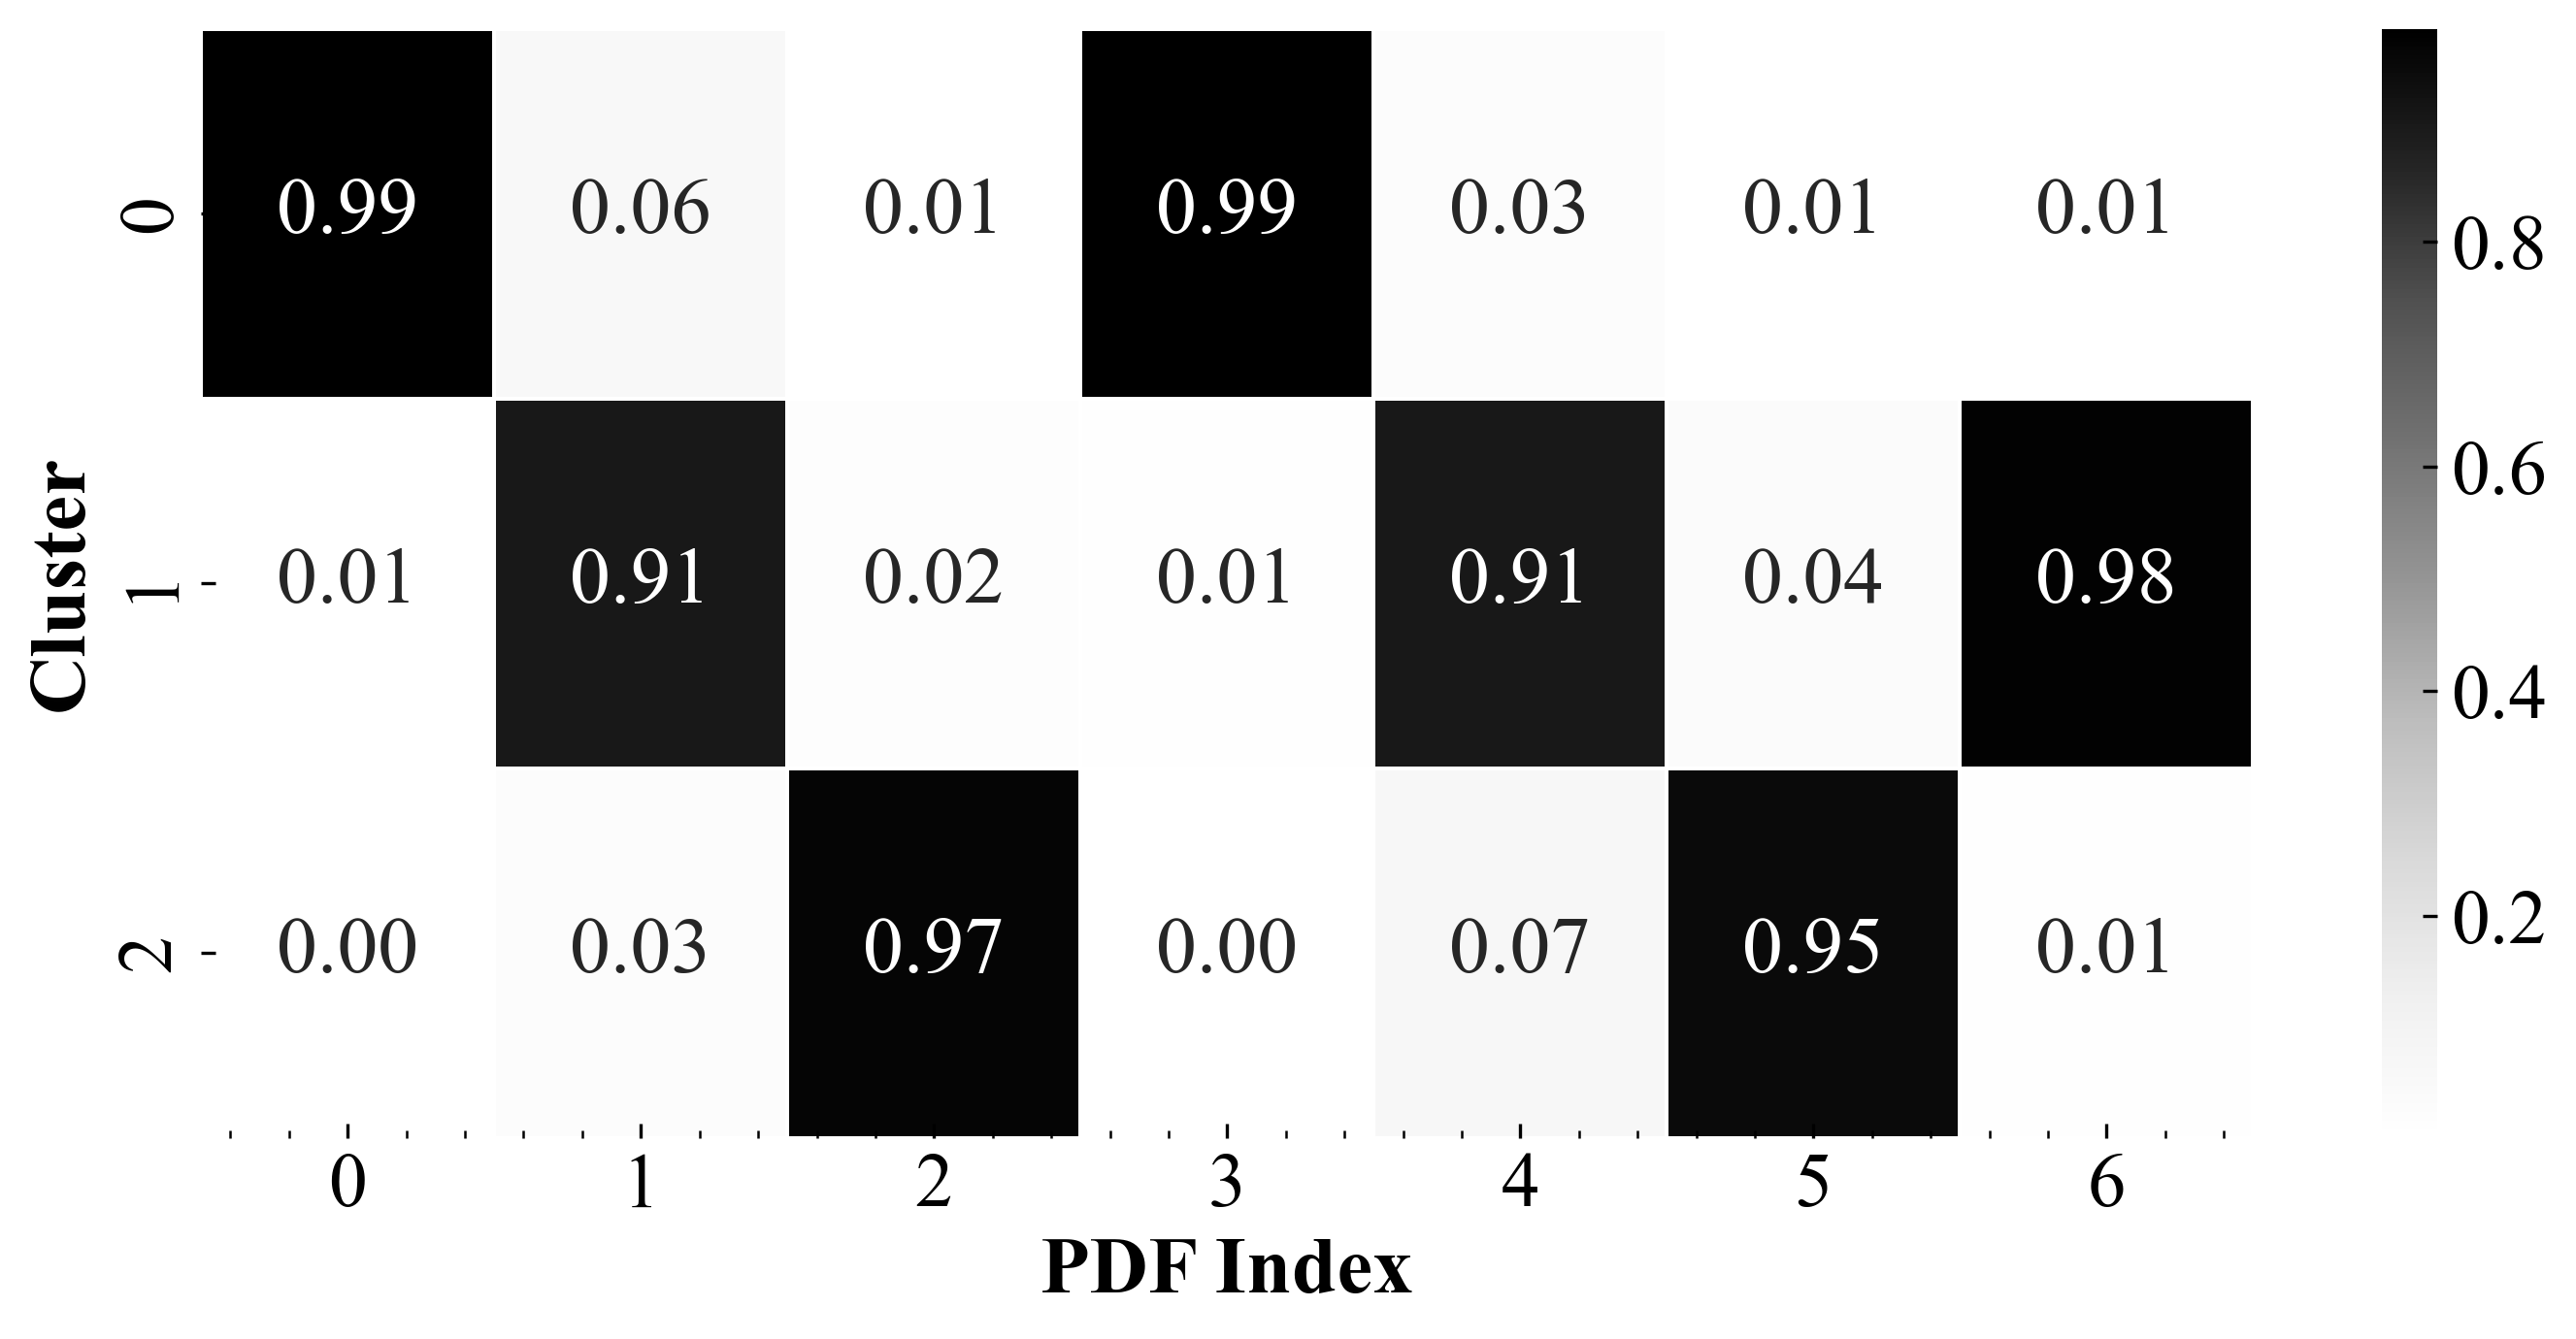

In [165]:
# plotHeatmap_U(U)
plt.figure(figsize=(10, 5))
temp(fontsize=20)

sns.heatmap(
	U,
	annot=True,
	fmt=".2f",
	cmap='Greys',
	cbar=True,
	linewidths=0.5,
	linecolor='white'
)

plt.ylabel('Cluster')
plt.xlabel('PDF Index')
plt.tight_layout()

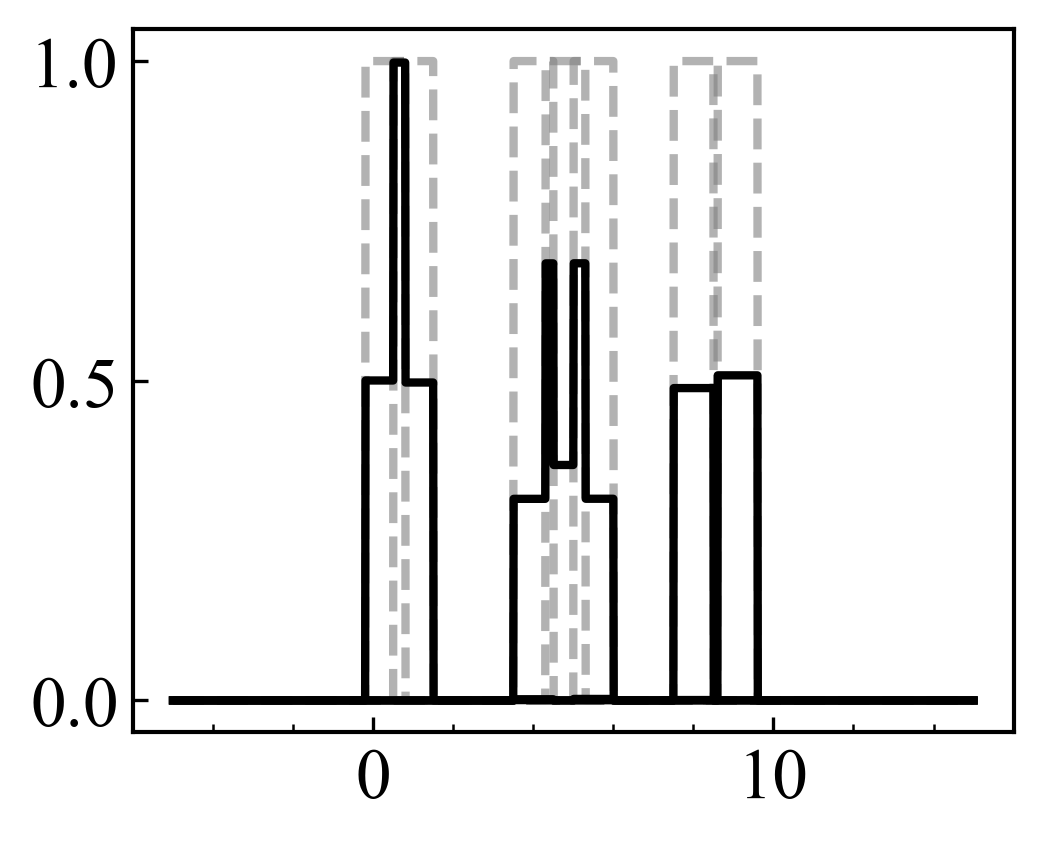

In [166]:
# plotPDF_Theta(grid_x, F_data, theta=Theta)
plt.figure()
temp(fontsize=18, w=12, h=8, u='centimeters')

# pdfs
for i in range(cluster.num_pdfs):
	plt.plot(grid_x, F_data[i, :], lw=2, color='gray', linestyle='--', alpha=0.6)

# prototype
for j in range(cluster.num_clusters):
	plt.plot(grid_x, Theta[j, :], lw=2, linestyle='-', color='black')

plt.tight_layout()

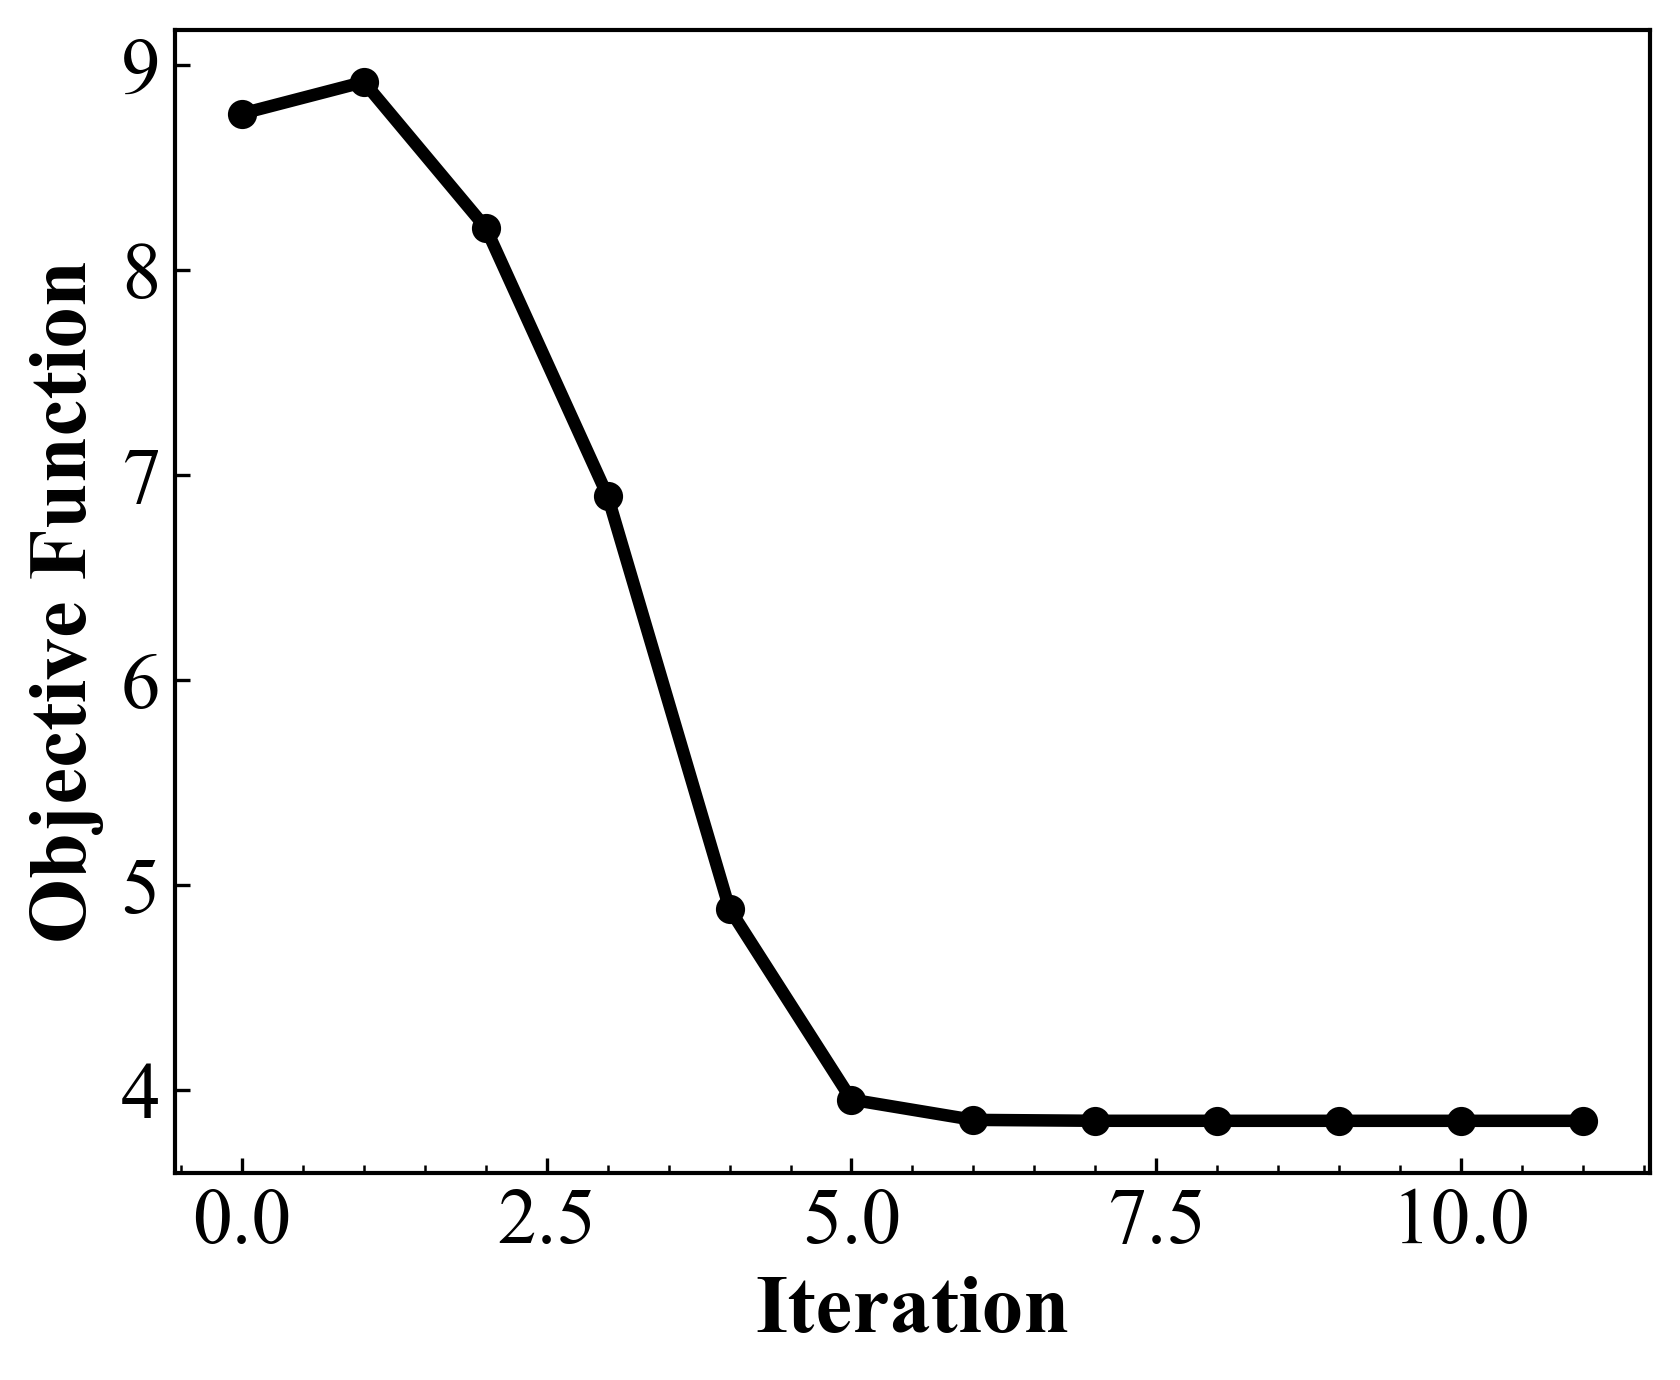

In [167]:
# plot_OF(J)
plt.figure(figsize=(6, 5))
temp(fontsize=20)

plt.plot(J, lw = 3,color = 'black', marker='o')
plt.xlabel("Iteration")
plt.ylabel("Objective Function")
plt.tight_layout()

In [168]:
from utils.vali import CVI

evaluator = CVI(distance_metric='L2',bandwidth=bandwidth, grid=grid_x)


sil = evaluator.silhouette_index(F_data, labels)
dunn = evaluator.dunn_index(F_data, labels)
dbi = evaluator.davies_bouldin_index(F_data, labels)

print(f"Silhouette = {sil:.4f}, Dunn = {dunn:.4f}, DBI = {dbi:.4f}")

Silhouette = 0.4775, Dunn = 1.0000, DBI = 1.4202


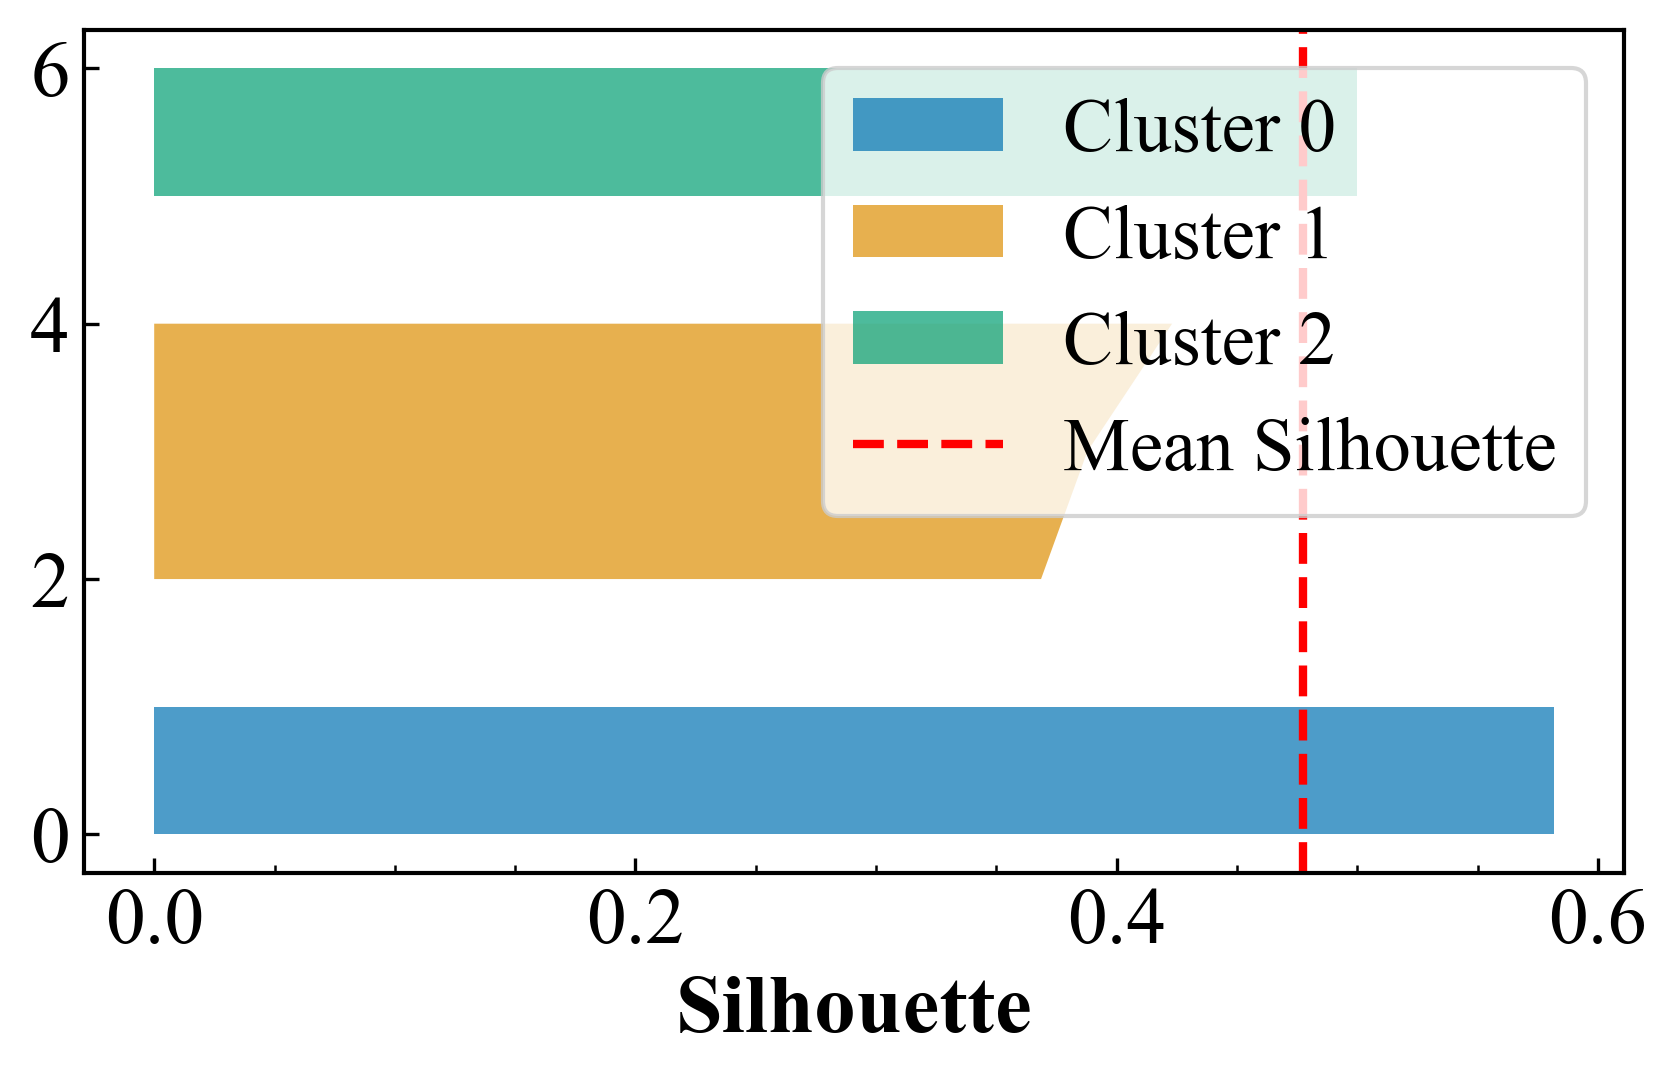

Silhouette fj: [0.58166999 0.36852427 0.5        0.58166999 0.38777999 0.5
 0.42297093]


In [169]:
sil_values = plot_silhouette_values(F_data, labels,
                                    distance_metric='L2',
                                    bandwidth=bandwidth,
                                    grid=grid_x)
print("Silhouette fj:", sil_values)

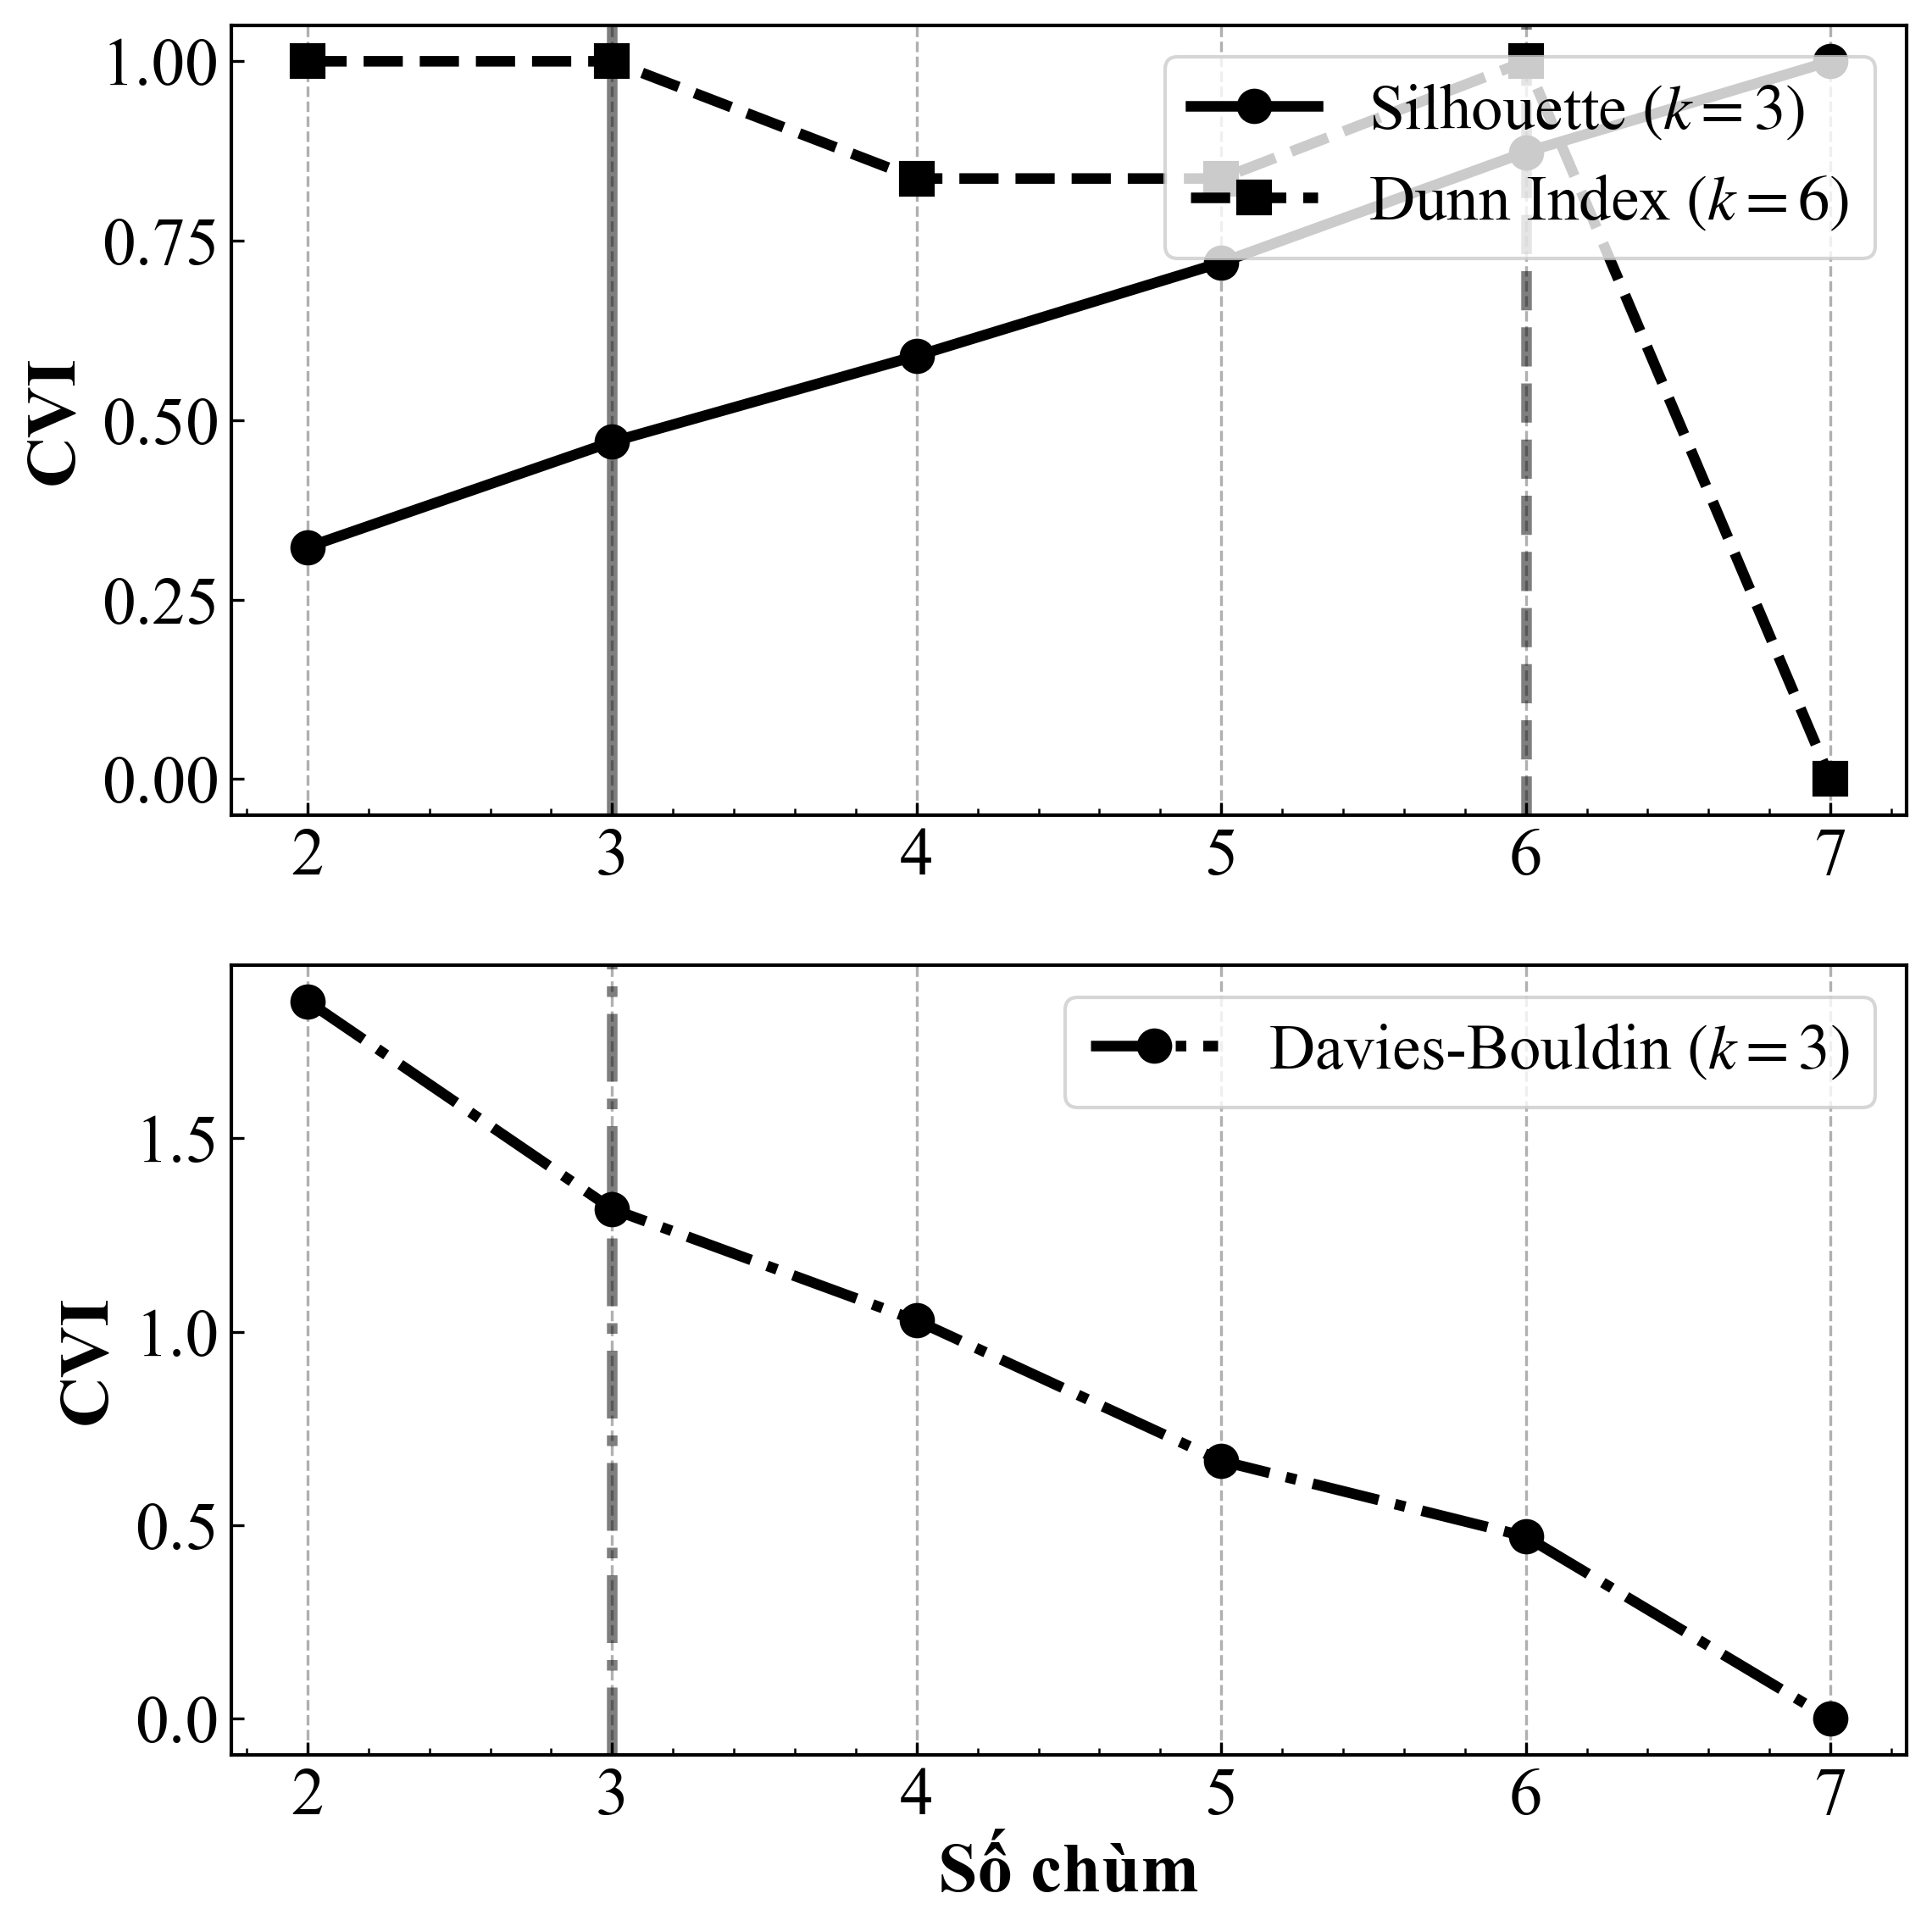

In [170]:
num_clusters_range = range(2, 8)
silhouette_scores, dunn_scores, dbi_scores = [], [], []

for k in num_clusters_range:
	cluster = FCF.Model(
	grid_x=grid_x,
	num_clusters=k,
	fuzziness=2,
	max_iterations=100,
	tolerance=1e-5,
	# centroid_mode="frechet",
	distance_metric='L2',
	verbose=False
	)
	cluster.fit(F_data)
	labels = cluster.get_hard_assignments()
	evaluator = CVI(distance_metric='L2', bandwidth=bandwidth, grid=grid_x)

	sil = evaluator.silhouette_index(F_data, labels)
	dunn = evaluator.dunn_index(F_data, labels)
	dbi = evaluator.davies_bouldin_index(F_data, labels)

	silhouette_scores.append(sil)
	dunn_scores.append(dunn)
	dbi_scores.append(dbi)

plot_CVI_with_k(num_clusters_range, silhouette_scores, dunn_scores, dbi_scores)